# Positive vs. Negative Sentiment Classification

Here we demonstrate how to explain a sentiment classification model for movie reviews. positive vs. negative sentim

In [1]:
import datasets
import numpy as np
import transformers

import shap

## Load the IMDB movie review dataset

In [2]:
dataset = datasets.load_dataset("imdb", split="test")

# shorten the strings to fit into the pipeline model
short_data = [v[:500] for v in dataset["text"][:20]]

## Load and run a sentiment analysis pipeline

In [3]:
classifier = transformers.pipeline("sentiment-analysis", return_all_scores=True)
classifier(short_data[:2])

2026-01-29 09:33:41.980716: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu
/home/margotte/Mestrado/GPU/shap/.venv/lib/python3.12/site-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


[[{'label': 'NEGATIVE', 'score': 0.07582101970911026},
  {'label': 'POSITIVE', 'score': 0.924178957939148}],
 [{'label': 'NEGATIVE', 'score': 0.018342547118663788},
  {'label': 'POSITIVE', 'score': 0.9816573858261108}]]

## Explain the sentiment analysis pipeline

In [4]:
# define the explainer
explainer = shap.Explainer(classifier)

In [5]:
# explain the predictions of the pipeline on the first two samples
shap_values = explainer(short_data[:2])

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:37, 18.86s/it]               


In [6]:
shap.plots.text(shap_values[:, :, "POSITIVE"])

## Wrap the pipeline manually

SHAP requires tensor outputs from the classifier, and explanations works best in additive spaces so we transform the probabilities into logit values (information values instead of probabilites).

### Create a TransformersPipeline wrapper

In [8]:
pmodel = shap.models.TransformersPipeline(classifier, rescale_to_logits=False)

In [9]:
pmodel(short_data[:2])

array([[0.07582102, 0.92417896],
       [0.01834255, 0.98165739]])

In [10]:
pmodel = shap.models.TransformersPipeline(classifier, rescale_to_logits=True)
pmodel(short_data[:2])

array([[-2.5005302 ,  2.50052988],
       [-3.98001908,  3.98001536]])

In [11]:
explainer2 = shap.Explainer(pmodel)
shap_values2 = explainer2(short_data[:2])
shap.plots.text(shap_values2[:, :, 1])

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:33, 16.74s/it]               


### Pass a tokenizer as the masker object

In [12]:
explainer2 = shap.Explainer(pmodel, classifier.tokenizer)
shap_values2 = explainer2(short_data[:2])
shap.plots.text(shap_values2[:, :, 1])

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:34, 17.28s/it]               


### Build a Text masker explicitly

In [13]:
masker = shap.maskers.Text(classifier.tokenizer)
explainer2 = shap.Explainer(pmodel, masker)
shap_values2 = explainer2(short_data[:2])
shap.plots.text(shap_values2[:, :, 1])

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:34, 17.19s/it]               


## Explore how the Text masker works

In [14]:
masker.shape("I like this movie.")

(1, 7)

In [15]:
model_args = masker(np.array([True, True, True, True, True, True, True]), "I like this movie.")
model_args

(array(['I like this movie.'], dtype='<U18'),)

In [16]:
pmodel(*model_args)

array([[-8.90780447,  8.90786191]])

In [17]:
model_args = masker(np.array([True, True, False, False, True, True, True]), "I like this movie.")
model_args

(array(['I [MASK] [MASK]movie.'], dtype='<U21'),)

In [18]:
pmodel(*model_args)

array([[-3.72091308,  3.72091284]])

In [19]:
masker2 = shap.maskers.Text(classifier.tokenizer, mask_token="...", collapse_mask_token=True)

In [20]:
model_args2 = masker2(np.array([True, True, False, False, True, True, True]), "I like this movie.")
model_args2

(array(['I ...movie.'], dtype='<U11'),)

In [21]:
pmodel(*model_args2)

array([[-3.20817846,  3.20817796]])

## Plot summary statistics and bar charts

In [22]:
# explain the predictions of the pipeline on the first two samples
shap_values = explainer(short_data[:20])

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   5%|▌         | 1/20 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  15%|█▌        | 3/20 [00:33<02:14,  7.91s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 4/20 [00:50<03:07, 11.71s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██▌       | 5/20 [01:07<03:27, 13.81s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███       | 6/20 [01:25<03:33, 15.26s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  35%|███▌      | 7/20 [01:43<03:29, 16.12s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|████      | 8/20 [02:01<03:17, 16.49s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  45%|████▌     | 9/20 [02:20<03:10, 17.34s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 10/20 [02:41<03:04, 18.44s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  55%|█████▌    | 11/20 [03:00<02:47, 18.62s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 12/20 [03:18<02:28, 18.58s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  65%|██████▌   | 13/20 [03:37<02:10, 18.65s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|███████   | 14/20 [03:57<01:54, 19.06s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████▌  | 15/20 [04:15<01:34, 18.82s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 16/20 [04:32<01:13, 18.28s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  85%|████████▌ | 17/20 [04:49<00:53, 17.85s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|█████████ | 18/20 [05:06<00:35, 17.62s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  95%|█████████▌| 19/20 [05:22<00:17, 17.20s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 20/20 [05:41<00:00, 17.61s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 21it [06:00, 18.05s/it]                        


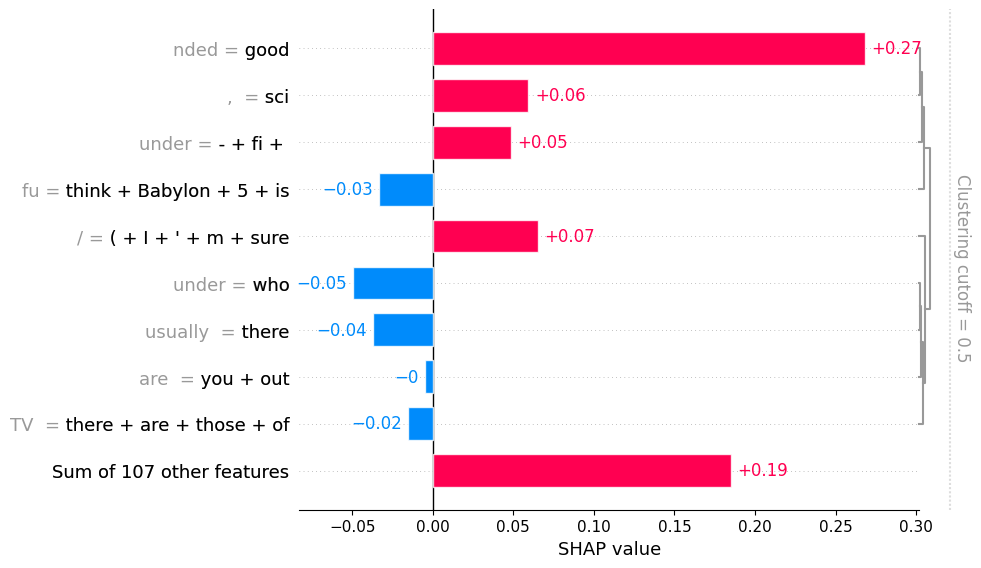

In [23]:
shap.plots.bar(shap_values[0, :, "POSITIVE"])

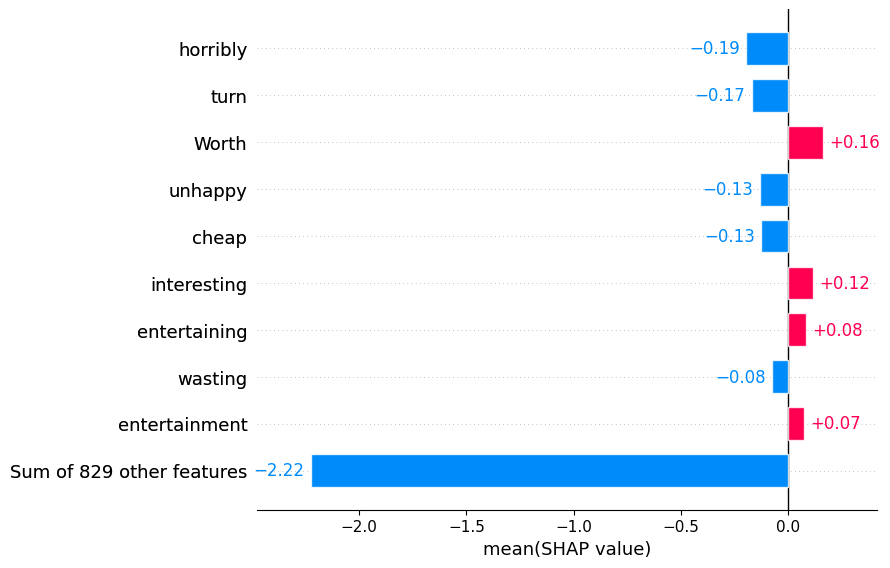

In [24]:
shap.plots.bar(shap_values[:, :, "POSITIVE"].mean(0))

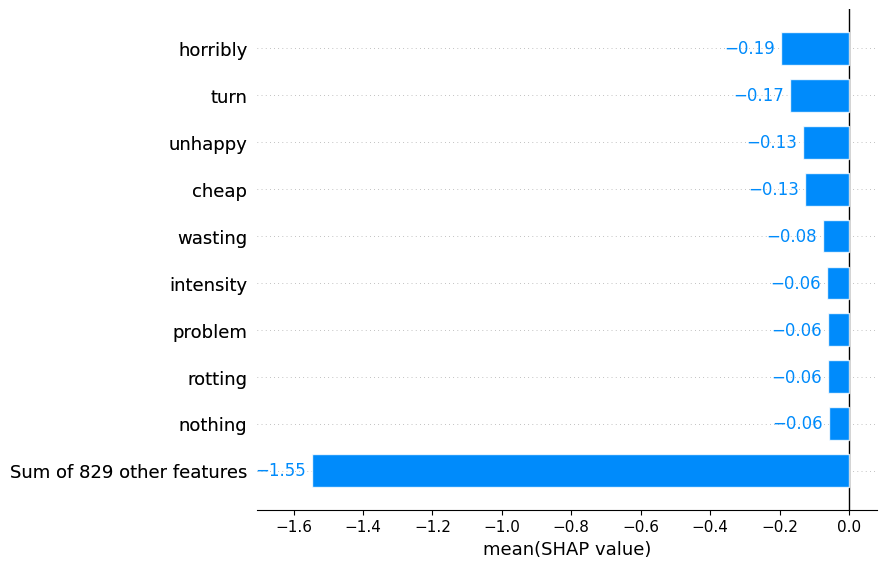

In [25]:
shap.plots.bar(shap_values[:, :, "POSITIVE"].mean(0), order=shap.Explanation.argsort)